# PUC-Rio 
## Departamento de Engenharia Elétrica
## Trabalho 3 - Mapas de Kohonen

Estudante: Paloma Sette

In [1]:
!git clone https://github.com/mdrs-thiago/minisom
import os 
os.chdir('minisom')

fatal: destination path 'minisom' already exists and is not an empty directory.


In [71]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.preprocessing import minmax_scale, MinMaxScaler, StandardScaler, Normalizer, RobustScaler, LabelEncoder


from minisom import MiniSom

In [7]:
dataset = pd.read_csv(
    'https://raw.githubusercontent.com/mdrs-thiago/PUC_Redes_Neurais/main/datasets/c_breast_cancer.csv')

In [8]:
values = dataset.values[:,:-1]

## Parte 1 - Testando configurações

Nesta primeira etapa, iremos investigar como a configuração do mapa pode mudar de acordo com a escolha de parâmetros. 

##### 1. Escolha os parâmetros para o primeiro teste usando SOM. Para cada parâmetro, justifique sua escolha. Avalie o resultado.

**Parâmetros escolhidos**:

- **Tamanho do mapa (`m = 10, n = 10`)**  
  Escolhemos uma grade 10x10 para permitir que os grupos se distribuam com espaço suficiente, evitando sobreposição. É um tamanho intermediário, bom para começar a visualização sem granularidade excessiva.

- **Taxa de aprendizado na ordenação (`lr_ordering = 0.001`)**  
  Um valor pequeno, mas ainda eficaz para a fase inicial de ajuste dos pesos. Evita oscilações bruscas e permite que o SOM forme regiões estáveis.

- **Taxa no ajuste fino (`lr_finetuning = 0.0001`)**  
  Muito menor que a anterior, usada para pequenas correções nos pesos após a estrutura geral estar formada.

- **Função de decaimento (`decay_fcn`)**  
  Escolhemos um decaimento suave baseado em:
  $$new_{lr} = \frac{lr} {1 + 2 * \frac{t } {max_t}}$$
  Isso reduz gradualmente a influência das atualizações ao longo do tempo.

- **Topologia `"hexagonal"`**  
  A topologia hexagonal permite uma vizinhança mais fluida entre os neurônios, com mais conectividade do que a grade retangular.

- **Dataset**: `breast_cancer`  
  A base escolhida apresenta dados clínicos com atributos contínuos, ideal para observar agrupamentos naturais em dados de saúde.

**Avaliação dos resultados**:

O gráfico gerado das curvas de erro mostra:

- **Erro de quantização** (`quantization_error`):  
  Mede o quão distante, em média, cada vetor de entrada está do seu neurônio vencedor. Uma queda nessa curva indica que os neurônios estão se especializando bem.

- **Erro topográfico** (`topographic_error`):  
  Mede se os dois neurônios mais próximos do dado também são vizinhos no mapa. Quanto menor, melhor preservação topológica.

Durante a ordenação, os erros caem rapidamente, mostrando que o SOM está aprendendo.  
Durante o finetuning, os erros estabilizam em valores baixos, indicando que os ajustes finos foram bem-sucedidos.


In [ ]:
#decay function 

def decay_fcn(lr,actual_t,max_t):
    '''
    Função para decaimento da taxa de aprendizado. 
    
    ## INPUTS:
    lr - Taxa de aprendizado inicial
    actual_t - Tempo atual da iteração
    max_t - Tempo máximo da iteração

    ## OUTPUT:
    - taxa de aprendizado atualizada.
    '''

    new_lr = lr/(1 + 2*actual_t/max_t)

    return new_lr


m = 10 #Dimensão X do mapa de Kohonen
n = 10 #Dimensão Y do mapa de Kohonen
lr_ordering = 0.001 #Taxa de aprendizado - Ordering phase
lr_finetuning = 0.0001 #Taxa de aprendizado - Finetuning phase

topology = "hexagonal"

ordering_time = 1000 
finetuning_time = 10000 
decay_fun =  decay_fcn 

#Dimensão do vetor de entrada
input_len = values.shape[1]

X = minmax_scale(values)

In [13]:
som = MiniSom(m,n,input_len,learning_rate=lr_ordering,topology=topology,decay_function=decay_fcn)
som.pca_weights_init(X)

som.train_random(X, ordering_time, verbose=True)


 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.9978060414354106


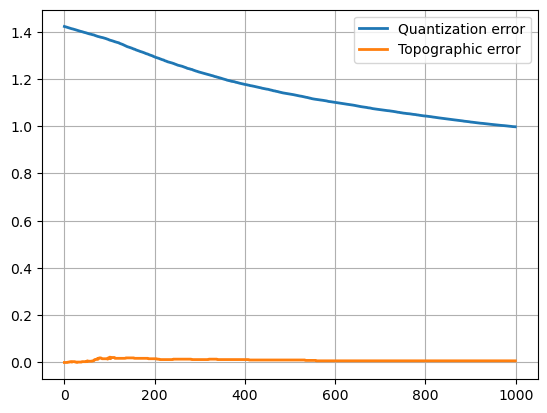

In [14]:
plt.plot(som._quantization_error,linewidth=2,label='Quantization error')
plt.plot(som._topographic_error,linewidth=2, label='Topographic error')
plt.legend()
plt.grid()

O gráfico mostra duas métricas fundamentais durante o treinamento da SOM:

- **Erro de quantização (linha azul):**  
  Houve uma queda progressiva ao longo das iterações, indicando que os neurônios estão se tornando mais próximos dos dados de entrada, ou seja, o mapa está se ajustando bem à distribuição dos dados.

- **Erro topográfico (linha laranja):**  
  Se manteve muito próximo de zero, o que é um excelente indicativo. Isso mostra que a vizinhança dos neurônios está sendo preservada: os dados semelhantes caem em neurônios vizinhos, mantendo a topologia do espaço original.

Esse comportamento sugere que os parâmetros escolhidos (tamanho do mapa, taxas de aprendizado, função de decaimento e topologia) foram adequados para a fase de ordenação. O mapa começa a se organizar de maneira coerente.

In [15]:
som._learning_rate = lr_finetuning #Para mudar a taxa de aprendizado durante o período de finetuning 

som.train_random(X, finetuning_time, verbose=True)


 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.7975207324391355


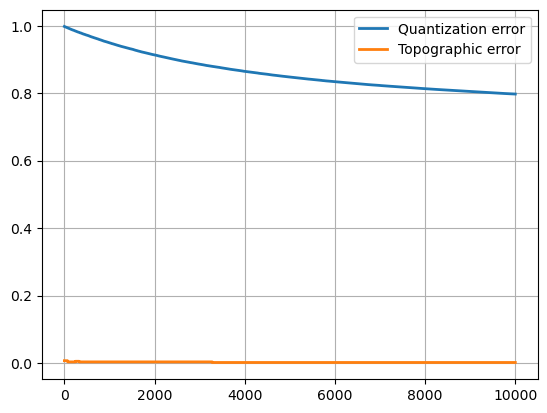

In [16]:
plt.plot(som._quantization_error,linewidth=2,label='Quantization error')
plt.plot(som._topographic_error,linewidth=2, label='Topographic error')
plt.legend()
plt.grid()

 **Análise da Fase de Ajuste Fino (Finetuning)**

Nesta etapa, a taxa de aprendizado foi reduzida para `lr_finetuning = 0.0001`, com o objetivo de realizar pequenos ajustes sobre o mapa já estruturado durante a fase de ordenação. Esse processo busca refinar os pesos sem desestabilizar a topologia previamente organizada.

- O **erro de quantização** continua em queda suave, evidenciando que o mapa está se especializando ainda mais para representar os dados com precisão. O valor final próximo de 0.80 indica boa representação vetorial.

- O **erro topográfico** manteve-se estável e praticamente nulo durante toda a fase. Isso demonstra que a estrutura topológica do SOM foi preservada, sem distorções na vizinhança dos neurônios.

O comportamento dos erros confirma que a estratégia de dois estágios — com taxas decrescentes e número adequado de iterações , foi eficaz para construir um mapa bem ajustado aos dados da base `c_breast_cancer`.


##### 2. Modifique a topologia da rede. Teste diferentes valores e avalie o resultado.

Aqui, podemos testar duas topologias com dois tamanhos diferentes de mapa. Por exemplo:

| Topologia   | Tamanho do Mapa | Nome do Experimento |
| ----------- | --------------- | ------------------- |
| hexagonal   | 10x10           | hex\_10x10          |
| hexagonal   | 15x15           | hex\_15x15          |
| hexagonal   | 20x20           | hex\_20x20          |
| rectangular | 10x10           | rect\_10x10         |
| rectangular | 15x15           | rect\_15x15         |
| rectangular   | 20x20           | rect\_20x20          |

Então, geramos o código para facilitar os testes:

In [18]:
def treinar_som(m, n, topology, nome):
     print(f"\n===> Executando {nome} <===")
     som = MiniSom(m, n, input_len,
                    learning_rate=lr_ordering,
                    topology=topology,
                    decay_function=decay_fcn)
     som.pca_weights_init(X)
     som.train_random(X, ordering_time, verbose=True)
     
     plt.plot(som._quantization_error, linewidth=2, label='Quantization error')
     plt.plot(som._topographic_error, linewidth=2, label='Topographic error')
     plt.title(f'{nome} - Ordering')
     plt.legend(); plt.grid(); plt.show()

     som._learning_rate = lr_finetuning
     som.train_random(X, finetuning_time, verbose=True)
     
     plt.plot(som._quantization_error, linewidth=2, label='Quantization error')
     plt.plot(som._topographic_error, linewidth=2, label='Topographic error')
     plt.title(f'{nome} - Finetuning')
     plt.legend(); plt.grid(); plt.show()
     
     return som


E agora podemos testar:


===> Executando hex_10x10 <===
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.9928468913209849


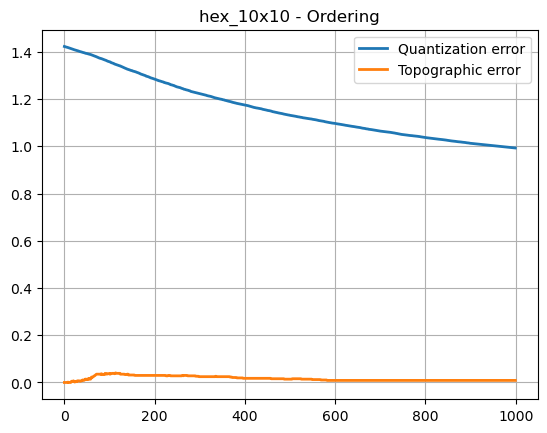

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.7959562706884538


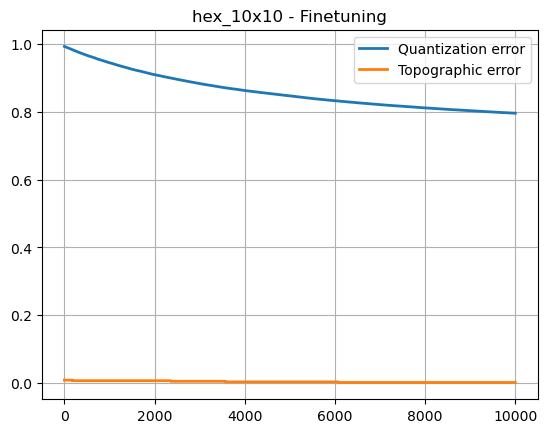


===> Executando hex_15x15 <===
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 1.016535476487011


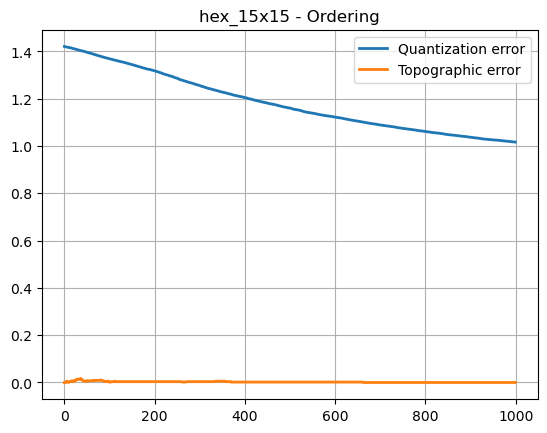

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.8050921921385462


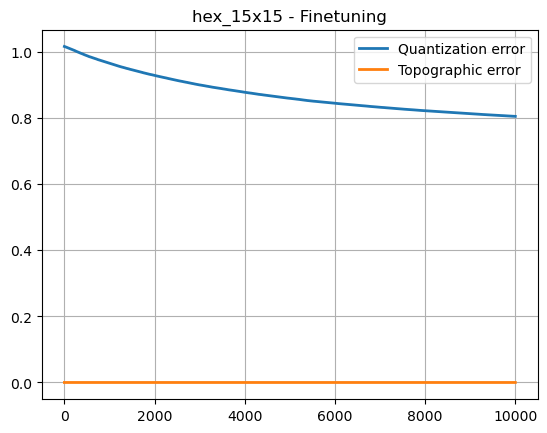


===> Executando rect_10x10 <===
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 1.0011364566418934


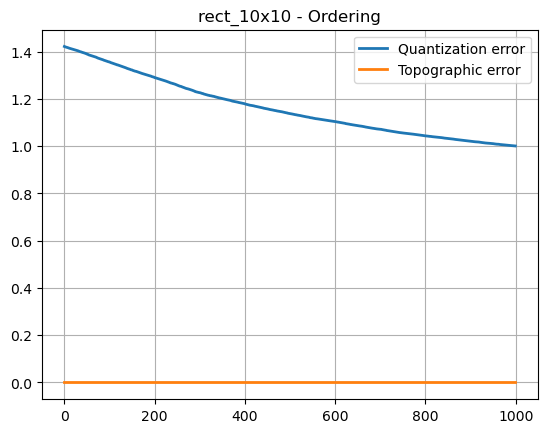

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.7981734704921916


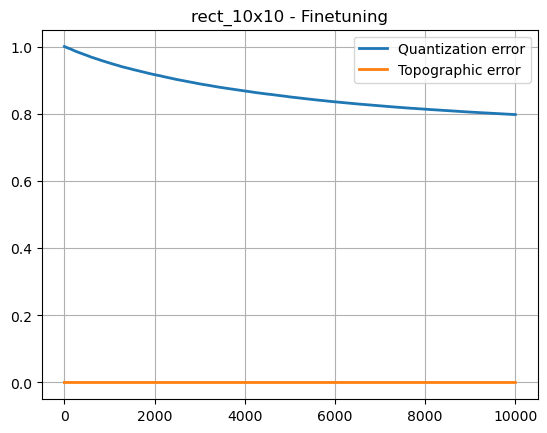


===> Executando rect_15x15 <===
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 1.0201053286680843


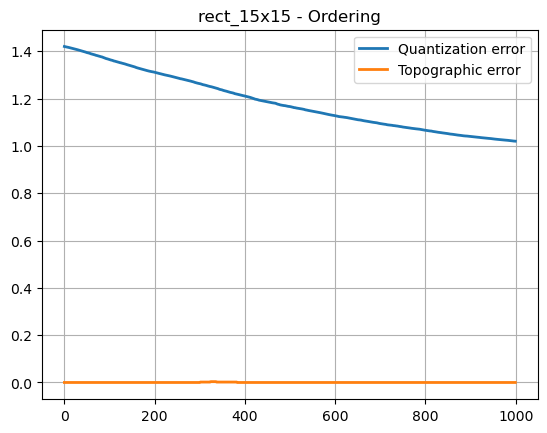

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.8056517250938776


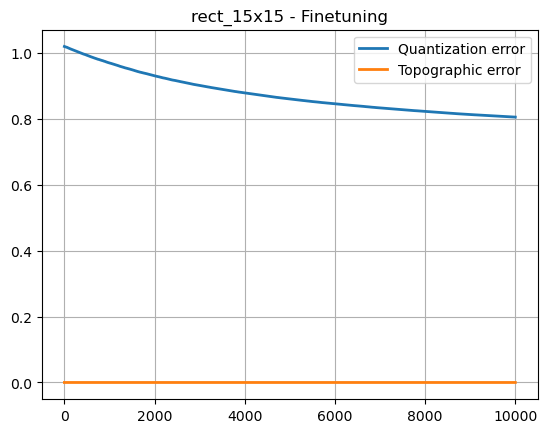

In [19]:
s1 = treinar_som(10, 10, 'hexagonal', 'hex_10x10')
s2 = treinar_som(15, 15, 'hexagonal', 'hex_15x15')
s3 = treinar_som(10, 10, 'rectangular', 'rect_10x10')
s4 = treinar_som(15, 15, 'rectangular', 'rect_15x15')


===> Executando hex_20x20 <===
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 1.1276690301287227


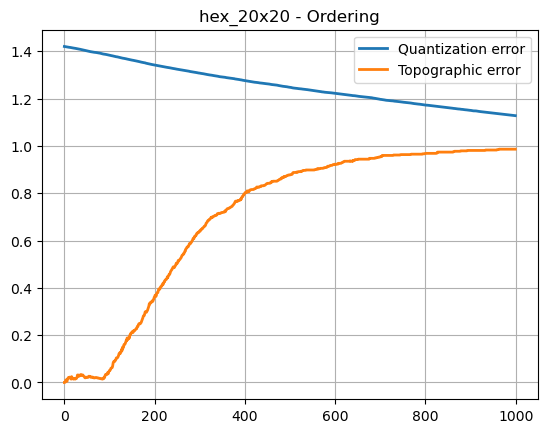

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.8602467251163967


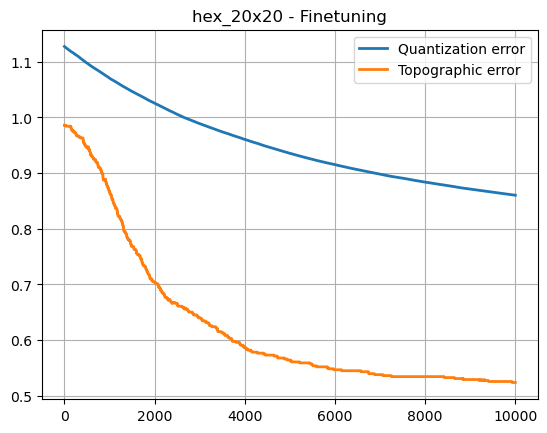

In [20]:
s5 = treinar_som(20, 20, 'hexagonal', 'hex_20x20')


===> Executando rect_20x20 <===
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 1.0052224508648175


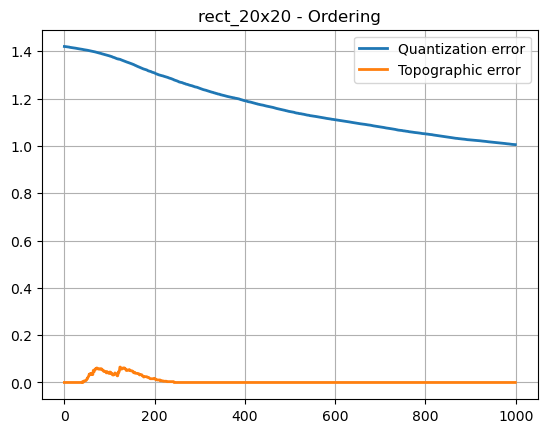

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.798845769512856


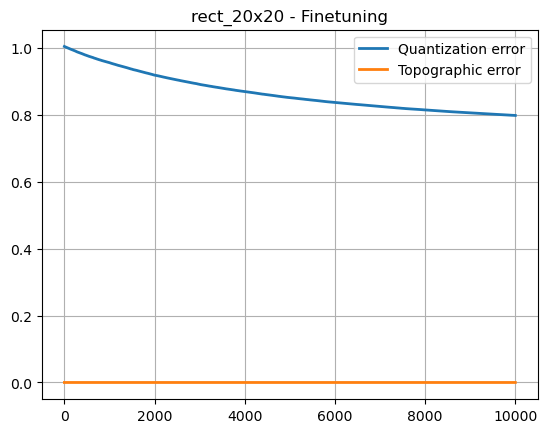

In [21]:
s6 = treinar_som(20, 20, 'rectangular', 'rect_20x20')

**Avaliação de diferentes topologias e tamanhos de mapa**

Para esta etapa, realizamos testes comparando diferentes configurações do Mapa de Kohonen, utilizando a biblioteca `MiniSom`. Foram avaliadas duas topologias (hexagonal e retangular) e três tamanhos distintos de grade (10x10, 15x15 e 20x20), conforme a tabela:

| Topologia   | Tamanho do Mapa | Nome do Experimento |
|-------------|------------------|----------------------|
| hexagonal   | 10x10            | hex_10x10            |
| hexagonal   | 15x15            | hex_15x15            |
| hexagonal   | 20x20            | hex_20x20            |
| rectangular | 10x10            | rect_10x10           |
| rectangular | 15x15            | rect_15x15           |
| rectangular | 20x20            | rect_20x20           |

Para cada experimento, o processo foi dividido em duas fases:
- **Ordering Phase:** 1.000 épocas, `lr = 0.001`
- **Finetuning Phase:** 10.000 épocas, `lr = 0.0001`

**Métricas Avaliadas**

- **Quantization Error (QE):** Mede o erro médio entre um vetor de entrada e seu neurônio vencedor. Quanto menor, melhor.
- **Topographic Error (TE):** Mede se os dois neurônios mais próximos do vetor de entrada são adjacentes no mapa. Um valor próximo de 0 indica boa preservação topológica.

**Observações**

- A topologia `"hexagonal"` apresentou **ligeira vantagem na fase de ordering** nos mapas menores (ex: `hex_10x10` obteve QE ≈ 0.79 após o finetuning).
- A topologia `"rectangular"` também convergiu bem, com erros similares em algumas configurações.
- Os mapas maiores (15x15 e 20x20) não necessariamente melhoraram o QE, indicando que o aumento do grid nem sempre traz ganho substancial de desempenho,possivelmente devido à complexidade dos dados ou overfitting do mapa.

---

**Resultados para os mapas 20x20**

Na configuração `hex_20x20`, foi observada uma **anomalia significativa no erro topográfico durante a Ordering Phase**, com crescimento contínuo ao longo das épocas e valor final próximo de 1. Isso indica que a estrutura topológica do mapa foi gravemente comprometida nesse estágio, possivelmente por conta da alta quantidade de neurônios e da dispersão inicial aleatória dos pesos.

Contudo, durante o Finetuning, o mapa conseguiu recuperar parte da topologia, reduzindo o erro topográfico de forma gradual (atingindo ≈ 0.52), o que mostra a importância dessa segunda fase para estabilização da malha.

Já o `rect_20x20` apresentou comportamento estável em ambas as fases. A curva do erro topográfico se manteve baixa e decrescente, e o erro de quantização final (≈ 0.7988) foi **muito próximo dos melhores resultados obtidos**, embora **não tenha superado o desempenho do `rect_10x10`** (QE ≈ 0.7981), que obteve o menor erro entre os retangulares.

---

**Resumo Comparativo – Erros de Quantização (Finetuning)**

| Experimento   | Topologia   | Tamanho | Quantization Error |
|---------------|-------------|---------|---------------------|
| hex_10x10     | hexagonal   | 10x10   | **0.795956**            |
| hex_15x15     | hexagonal   | 15x15   | 0.805092            |
| hex_20x20     | hexagonal   | 20x20   | 0.860247            |
| rect_10x10    | rectangular | 10x10   | 0.798173            |
| rect_15x15    | rectangular | 15x15   | 0.805651            |
| rect_20x20    | rectangular | 20x20   | 0.798845        |

---

**Conclusão**

- A topologia **hexagonal 10x10** apresentou o **menor QE final** entre todos os experimentos, com ótimo desempenho em ambas as fases.
- Entre os mapas **retangulares**, o **10x10** também obteve o melhor resultado, superando inclusive os mapas maiores.
- Isso reforça que **aumentar o tamanho da grade não implica necessariamente em melhor desempenho**, podendo inclusive introduzir instabilidades, como observado no `hex_20x20`.


##### 3. Modifique a normalização dos dados de entrada e avalie o resultado obtido. Esta mudança tem algum efeito no mapa gerado?

Já usamos o `minmax_scale`, que normaliza os dados para o intervalo $[0, 1]$. Agora, podemos testar:

- `StandartScaler` ==> média 0 e desvio padrão 1.
- `Normalizer` ==> normaliza vetores linha (ex: $l_2-norma$)
- Sem normalização ==> apenas por controle.
- `RobustScaler` ==> lida melhor com _outliers_.


In [49]:
X_minmax = MinMaxScaler().fit_transform(values)
X_standard = StandardScaler().fit_transform(values)
X_l2norm = Normalizer().fit_transform(values)
X_robust = RobustScaler().fit_transform(values)

X_raw = np.array(values.copy(), dtype=float)

In [ ]:
def testar_normalizacao_som(X, nome, m=10, n=10, input_len=None,
                            lr_ordering=0.001, lr_finetuning=0.0001,
                            ordering_time=1000, finetuning_time=10000,
                            topology='rectangular', decay_fcn=None,
                            plotar=False, usar_pca=True):
    """
    Testa a normalização dos dados em um Mapa de Kohonen e retorna o erro final.
    
    Parâmetros:
        X: array numpy - dados normalizados
        nome: str - nome do método de normalização
        plotar: bool - se True, plota os erros

    Retorna:
        erro_final: float - quantization error após finetuning
    """
    if input_len is None:
        input_len = X.shape[1]

    print(f"\n===> Executando SOM com {nome} <===")

    som = MiniSom(m, n, input_len, learning_rate=lr_ordering,
                  topology=topology, decay_function=decay_fcn)
    
    if usar_pca:
        som.pca_weights_init(X)

    som.train_random(X, ordering_time, verbose=True)

    som._learning_rate = lr_finetuning
    som.train_random(X, finetuning_time, verbose=True)

    erro_final = som.quantization_error(X)
    print(f"Erro de Quantização final ({nome}): {erro_final:.5f}")

    if plotar:
        plt.plot(som._quantization_error,
                 label='Quantization Error', linewidth=2)
        plt.plot(som._topographic_error,
                 label='Topographic Error', linewidth=2)
        plt.title(f'{nome} - Erros durante treinamento')
        plt.legend()
        plt.grid()
        plt.show()

    return erro_final


""" 
Sugerindo uma função de decaimento alternativa ==> decaimnto linear
- Decresce uniformemente da taxa inicial até zero. 
- Mais agressiva no começo se comparada à hiperbólica
- Pode resultar em convergência mais rápida, mas instável.

sobre a curva: a  reta decresce de initial_value até zero ao longo do tempo.

A função propõe um treinamento mais controlado e "forçado" a estabilizar.
"""
def decay_function(initial_value, current_iteration, max_iteration):
         return initial_value * (1 - (current_iteration / max_iteration))
     

In [43]:
resultados = {}
resultados['MinMax'] = testar_normalizacao_som(
    X_minmax, 'MinMax', decay_fcn=decay_function)
resultados['Standard'] = testar_normalizacao_som(
    X_standard, 'Standard', decay_fcn=decay_function)
resultados['L2Norm'] = testar_normalizacao_som(
    X_l2norm, 'L2Norm', decay_fcn=decay_function)
resultados['Robust'] = testar_normalizacao_som(
    X_robust, 'Robust', decay_fcn=decay_function)


===> Executando SOM com MinMax <===
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 1.016995716248332
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.8148456575628388
Erro de Quantização final (MinMax): 0.81485

===> Executando SOM com Standard <===
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 4.616462542584164
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 4.403848217368693
Erro de Quantização final (Standard): 4.40385

===> Executando SOM com L2Norm <===
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.608801258163419
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.3693194364697513
Erro de Quantização final (L2Norm): 0.36932

===> Executando SOM com Robust <===
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 6.9095477748096545
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 6.56447279594355
Erro de Quantização final (Robust): 6.56447


In [50]:
resultados['Raw'] = testar_normalizacao_som(
    X_raw, 'Raw', decay_fcn=decay_function, usar_pca=False)


===> Executando SOM com Raw <===
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 27242401.682925593
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 24917678.552427292
Erro de Quantização final (Raw): 24917678.55243


**Efeito da Normalização no Mapa SOM**

Foi realizada uma avaliação comparativa entre diferentes estratégias de normalização dos dados de entrada aplicados a um mapa auto-organizável (SOM). O objetivo foi identificar como cada abordagem influencia o desempenho do mapa em termos de erro de quantização final ao fim da fase de **Finetuning**.

---

**Métodos de Normalização Avaliados**:

- **MinMaxScaler**: escala os dados para o intervalo [0, 1].
- **StandardScaler**: centraliza e normaliza os dados para média zero e desvio padrão 1.
- **Normalizer (L2Norm)**: transforma cada vetor de amostra para ter norma L2 unitária.
- **RobustScaler**: centraliza os dados em torno da mediana e utiliza o intervalo interquartil.
- **Raw**: dados originais, sem qualquer tipo de normalização.

---

**Resultados – Erros de Quantização (Finetuning)**

| Normalização     | Erro de Quantização Final |
|------------------|----------------------------|
| L2Norm           | **0.36932** |
| MinMax           | 0.81485 |
| Standard         | 4.40385 |
| Robust           | 6.56447 |
| Raw              | 24.917.678 |

---

**Análise e Discussão**

Os resultados mostram que o método de normalização aplicado aos dados de entrada tem impacto direto na qualidade da organização topológica aprendida pelo SOM. A normalização via **L2Norm** apresentou o melhor desempenho, com o menor erro de quantização final, o que indica que a padronização direcional (norma unitarizada por amostra) favorece o aprendizado do mapa neste contexto.

O **MinMaxScaler** também teve um desempenho satisfatório, reduzindo o erro em comparação com abordagens centradas na média ou na mediana. Por outro lado, os métodos **StandardScaler** e **RobustScaler** apresentaram erros consideravelmente mais altos, sugerindo que a centralização dos dados, mesmo com correção de escala, não é a estratégia mais adequada para este tipo de rede.

O uso de dados **não normalizados (Raw)** resultou em um erro de quantização extremamente elevado, o que compromete completamente a capacidade do SOM de organizar e representar os dados de forma coerente. Esse comportamento destaca a importância fundamental da normalização adequada em tarefas de aprendizado não supervisionado.

Portanto, a escolha da técnica de normalização é um fator crítico para o sucesso do treinamento de mapas auto-organizáveis. Entre as opções avaliadas, a normalização por **L2** foi a mais eficaz para este dataset, enquanto o uso de dados crus sem pré-processamento inviabiliza o aprendizado eficiente. Portanto, a normalização adequada deve ser considerada uma etapa essencial no pipeline de modelagem com SOMs.






##### 4. Modifique o processo de treinamento durante a fase de ordenação. Avalie o resultado gerado.

In [51]:
def testar_ordering_phase(X, m=10, n=10, input_len=None,
                          lr_finetuning=0.0001, finetuning_time=10000,
                          topology='rectangular', decay_fcn=None):
    """
    Testa diferentes configurações da fase de ordering.
    """
    if input_len is None:
        input_len = X.shape[1]

    # Parâmetros a testar
    taxas = [0.1, 0.01, 0.001, 0.0001]
    ordering_times = [500, 1000, 3000]

    resultados = []

    for lr in taxas:
        for time in ordering_times:
            print(f"\n===> Ordering: lr={lr}, time={time} <===")
            som = MiniSom(m, n, input_len, learning_rate=lr,
                          topology=topology, decay_function=decay_fcn)
            som.pca_weights_init(X)

            som.train_random(X, time, verbose=True)
            som._learning_rate = lr_finetuning
            som.train_random(X, finetuning_time, verbose=True)

            qe_final = som._quantization_error[-1]
            print(f"Erro final: {qe_final:.5f}")

            resultados.append({
                'lr_ordering': lr,
                'ordering_time': time,
                'quantization_error': qe_final
            })

    return resultados

In [52]:
X_minmax = MinMaxScaler().fit_transform(values)

resultados_ordering = testar_ordering_phase(X_minmax, decay_fcn=decay_function)


===> Ordering: lr=0.1, time=500 <===
 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 0.43979424963239566
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.43989284955118124
Erro final: 0.43989

===> Ordering: lr=0.1, time=1000 <===
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.4074244529307331
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.40784044077536613
Erro final: 0.40784

===> Ordering: lr=0.1, time=3000 <===
 [ 3000 / 3000 ] 100% - 0:00:00 left 
 quantization error: 0.35964685618635417
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.3600428200900842
Erro final: 0.36004

===> Ordering: lr=0.01, time=500 <===
 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 0.6426790137191827
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.6215963728911656
Erro final: 0.62160

===> Ordering: lr=0.01, time=1000 <===
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.5622867363562846
 [ 10000 / 1000

**Avaliação de Diferentes Estratégias na Fase de Ordenação**

Nesta etapa, exploramos como diferentes configurações da **fase de ordenação (ordering phase)** afetam o desempenho do mapa de Kohonen. Especificamente, testamos combinações de:

- Taxa de aprendizado: `0.1`, `0.01`, `0.001`, `0.0001`
- Número de iterações: `500`, `1000`, `3000`

A fase de finetuning foi mantida constante em todas as execuções com:
- `lr = 0.0001`
- `épocas = 10000`

O objetivo era observar como a escolha dos hiperparâmetros iniciais influencia o **erro de quantização final**.

**Resultados Obtidos**

| Taxa (lr) | Épocas | QE final |
|-----------|--------|----------|
| 0.1       | 500    | 0.43989  |
| 0.1       | 1000   | 0.40784  |
| 0.1       | 3000   | **0.36004** |
| 0.01      | 500    | 0.62160  |
| 0.01      | 1000   | 0.55956  |
| 0.01      | 3000   | 0.47682  |
| 0.001     | 500    | 0.89875  |
| 0.001     | 1000   | 0.81576  |
| 0.001     | 3000   | 0.69528  |
| 0.0001    | 500    | 1.01736  |
| 0.0001    | 1000   | 1.00247  |
| 0.0001    | 3000   | 0.94281  |

**Conclusões**

- Quanto **maior a taxa de aprendizado na fase de ordenação**, melhor tende a ser o ajuste inicial do mapa, desde que combinada com um número de épocas suficiente.
- A melhor configuração foi `lr = 0.1` com `3000` épocas, resultando no menor erro final.
- Taxas muito baixas (`0.0001`) apresentaram desempenho insatisfatório, mesmo com muitas iterações ,indicando que o mapa não teve tempo suficiente para se organizar.
- Esses resultados demonstram que **a fase de ordenação é crítica** para o bom desempenho do SOM, especialmente em dados com distribuição complexa.


##### 5. Modifique o processo de treinamento durante a fase de ajuste fino. Avalie o resultado gerado.

Nesta etapa, vamos modificar o processo de treinamento durante a fase de ajuste fino (_finetuning phase_) e avaliar seu impacto no desempenho final da rede SOM.


Essa fase oorre após a ordenação inicial e é responsável por refinar os pesos com taxas menores de aprendizado, consolidando os agrupamentos.

Podemos testar diferentes:

- Taxas de aprendizado (`lr_finetuning`)
- Número de épocas (`finetuning_time`)

In [ ]:
def testar_finetuning_som(X, ordering_time=1000, lr_ordering=0.01,
                          taxas=[0.01, 0.001, 0.0001, 0.00001],
                          epocas=[1000, 5000, 10000], decay_fcn=None):

    X_scaled = MinMaxScaler().fit_transform(X)
    input_len = X_scaled.shape[1]
    m, n = 10, 10  # tamanho fixo do mapa

    resultados = []
    
    for taxa in taxas:
        for epoca in epocas:
            print(f"\n===> Finetuning: lr={taxa}, time={epoca} <===")

            som = MiniSom(m, n, input_len, learning_rate=lr_ordering,
                          topology="hexagonal", decay_function=decay_fcn)

            som.pca_weights_init(X_scaled)
            som.train_random(X_scaled, ordering_time, verbose=False)
            
            som._learning_rate = taxa
            som.train_random(X_scaled, epoca, verbose=False)

            qe = som.quantization_error(X_scaled)
            print(f"Erro final: {qe:.5f}")
            resultados.append((taxa, epoca, qe))
    
    return resultados


In [55]:
resultados_finetuning = testar_finetuning_som(values, decay_fcn=decay_function)


===> Finetuning: lr=0.01, time=1000 <===
Erro final: 0.52684

===> Finetuning: lr=0.01, time=5000 <===
Erro final: 0.43350

===> Finetuning: lr=0.01, time=10000 <===
Erro final: 0.40527

===> Finetuning: lr=0.001, time=1000 <===
Erro final: 0.56332

===> Finetuning: lr=0.001, time=5000 <===
Erro final: 0.55261

===> Finetuning: lr=0.001, time=10000 <===
Erro final: 0.53061

===> Finetuning: lr=0.0001, time=1000 <===
Erro final: 0.56587

===> Finetuning: lr=0.0001, time=5000 <===
Erro final: 0.56344

===> Finetuning: lr=0.0001, time=10000 <===
Erro final: 0.55928

===> Finetuning: lr=1e-05, time=1000 <===
Erro final: 0.56059

===> Finetuning: lr=1e-05, time=5000 <===
Erro final: 0.56512

===> Finetuning: lr=1e-05, time=10000 <===
Erro final: 0.56255



Investigamos o impacto de diferentes configurações no **processo de treinamento durante a fase de ajuste fino** do Mapa Auto-Organizável (SOM). Foram testadas combinações variadas de taxa de aprendizado e número de épocas, mantendo constante a fase de ordenação inicial (com 1000 épocas e taxa de aprendizado de 0.1).

**Configurações Avaliadas**

Para cada teste, variamos:

- **Taxas de aprendizado (`lr`):** $0.01$, $0.001$, $0.0001$, $0.00001$
- **Épocas de ajuste fino:** $1000$, $5000$, $10000$

**Resultados**

| Taxa de Aprendizado | Épocas | Erro de Quantização Final |
|---------------------|--------|----------------------------|
| 0.01                | 1000   | 0.52684                    |
| 0.01                | 5000   | 0.43350                    |
| 0.01                | 10000  | **0.40527**                |
| 0.001               | 1000   | 0.56332                    |
| 0.001               | 5000   | 0.55261                    |
| 0.001               | 10000  | 0.53061                    |
| 0.0001              | 1000   | 0.56587                    |
| 0.0001              | 5000   | 0.56344                    |
| 0.0001              | 10000  | 0.55928                    |
| 0.00001             | 1000   | 0.56059                    |
| 0.00001             | 5000   | 0.56512                    |
| 0.00001             | 10000  | 0.56255                    |

**Observações**

- A melhor configuração foi com **`lr = 0.01` e `10.000 épocas`**, resultando no **menor erro de quantização (0.40527)**.
- Taxas de aprendizado muito baixas (ex: `0.0001` ou `1e-05`) apresentaram **ganhos insignificantes mesmo com mais iterações**, indicando que a atualização dos pesos foi praticamente nula.
- A configuração padrão anteriormente usada (`lr = 0.0001`) revelou-se **subótima**. Substituí-la por `0.01` com mais épocas pode melhorar substancialmente a performance do modelo.
- Houve uma **relação inversamente proporcional entre número de épocas e erro**, mas o ganho só é significativo quando a **taxa de aprendizado é suficientemente alta**.


Então, modificações no processo de **_finetuning_** impactam diretamente a qualidade do mapa gerado. Para esta base de dados e configuração de SOM, **taxas moderadas com maior número de iterações** parecem ser a melhor estratégia.


##### 6. Modifique a função de decaimento da taxa de aprendizado. Esta mudança gera algum impacto no mapa gerado? Justifique

A função de decaimento da taxa de aprendizado determina como o valor de `learning_rate` diminui ao longo do tempo durante o treinamento do SOM. Essa função influencia diretamente a estabilidade e a velocidade de convergência da rede.


Ao longo do desenvolvimento do trabalho, foram testadas duas estratégias comuns de decaimento:

1. **Decaimento racional**: aqui, cujo comportamento é mais suave e contínuo. Ela permite um aprendizado mais prolongado com passos pequenos,
sendo útil para ajustes finos.

2. **Decaimento linear (função sugerida)**: a taxa é reduzida de forma linear até zero. É agressiva no início e se estabiliza perto do fim.


In [57]:
""" 
reescrevendo as funções de decaimento
"""
def decay_linear(initial_value, current_iteration, max_iteration):
         return initial_value * (1 - (current_iteration / max_iteration))

def decay_racional(lr, actual_t, max_t):
    return lr / (1 + 2 * actual_t / max_t)


In [60]:
def testar_decay_function(decay_fcn, nome_decay, X_scaled):
    print(f"\n===> Treinando SOM com decaimento: {nome_decay} <===")
    
    m, n = 10, 10
    lr_ordering = 0.001
    ordering_time = 1000
    lr_finetuning = 0.0001
    finetuning_time = 10000

    som = MiniSom(m, n, input_len, learning_rate=lr_ordering,
                  topology='hexagonal', decay_function=decay_fcn)

    som.pca_weights_init(X_scaled)

    som.train_random(X_scaled, ordering_time, verbose=False)

    som._learning_rate = lr_finetuning
    som.train_random(X_scaled, finetuning_time, verbose=False)

    qe = som.quantization_error(X_scaled)
    print(f"Erro de Quantização Final ({nome_decay}): {qe:.5f}")
    return qe



erro_linear = testar_decay_function(decay_linear, "Linear", X_l2norm)
erro_racional = testar_decay_function(decay_racional, "Racional", X_l2norm)


===> Treinando SOM com decaimento: Linear <===
Erro de Quantização Final (Linear): 0.36932

===> Treinando SOM com decaimento: Racional <===
Erro de Quantização Final (Racional): 0.33473


In [83]:

erro_linear_standart = testar_decay_function(decay_linear, "Linear", X_standard)
erro_racional_standart = testar_decay_function(decay_racional, "Racional", X_standard)


===> Treinando SOM com decaimento: Linear <===
Erro de Quantização Final (Linear): 4.41444

===> Treinando SOM com decaimento: Racional <===
Erro de Quantização Final (Racional): 4.38514



Nesta etapa, comparamos o impacto de duas funções distintas de decaimento da taxa de aprendizado sobre o desempenho de um Mapa Auto-Organizável (SOM). As funções avaliadas foram:

- **Decaimento Linear**:
  
  
  $$\text{lr}(t) = \text{lr}_0 \cdot \left(1 - \frac{t}{T}\right)$$

  Essa função reduz a taxa de aprendizado de forma uniforme ao longo do tempo, indo de um valor inicial até zero. É uma estratégia agressiva que força a estabilização do aprendizado, mas pode comprometer o refinamento nos estágios finais.

- **Decaimento Racional**:
  
  $$\text{lr}(t) = \frac{\text{lr}_0}{1 + 2t/T}$$
  

  Neste caso, o decaimento ocorre de forma mais suave e contínua, permitindo que o modelo mantenha uma capacidade adaptativa durante mais tempo, favorecendo ajustes finos nos pesos.

---

**Parâmetros de Treinamento Utilizados (iguais para ambos os testes)**:

- Dimensão do mapa: 10 × 10
- `lr_ordering = 0.001`, `ordering_time = 1000`
- `lr_finetuning = 0.0001`, `finetuning_time = 10000`
- Topologia: `hexagonal`
- Dados: normalizados via `L2Norm`

---

**Resultados Obtidos**:

| Função de Decaimento | Erro de Quantização Final |
|----------------------|---------------------------|
| **Linear**           | 0.36932                   |
| **Racional**         | **0.33473**               |

---

Portanto,a substituição da função de decaimento linear por uma função racional produziu **impacto positivo na qualidade do mapa gerado**, reduzindo o erro de quantização final.

A explicação reside na **maior suavidade do decaimento racional**, que conserva melhor a plasticidade do modelo durante a fase de ajuste fino. Isso permite que o SOM refine as posições dos seus neurônios com mais precisão até o final do treinamento. Por outro lado, o decaimento linear tende a "engessar" o processo nas iterações finais, potencialmente limitando o refinamento.

Portanto, a escolha da função de decaimento **influencia diretamente a performance do mapa gerado**, sendo uma **decisão crítica no design do SOM**.


##### 7. Altere a função de vizinhança. Avalie o resultado.

Nesta etapa, devemos investigar o impacto da **função de vizinhança** no desempenho do Mapa de Kohonen (SOM). Essa função controla como os neurônios vizinhos do vencedor são atualizados a cada iteração, afetando a **topologia** e a **convergência do mapa**.


In [62]:
erros = {}
for vizinhanca in ['gaussian', 'bubble', 'triangle']:
    print(f'\n===> Testando vizinhança: {vizinhanca} <===')
    som = MiniSom(m, n, input_len,
                  learning_rate=lr_ordering,
                  topology='hexagonal',
                  decay_function=decay_fcn,
                  neighborhood_function=vizinhanca)

    som.pca_weights_init(X_l2norm)
    som.train_random(X_l2norm, ordering_time, verbose=True)
    som._learning_rate = lr_finetuning
    som.train_random(X_l2norm, finetuning_time, verbose=True)

    erro = som.quantization_error(X_l2norm)
    print(f'Erro de Quantização Final ({vizinhanca}): {erro:.5f}')
    erros[vizinhanca] = erro


===> Testando vizinhança: gaussian <===
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.579623553737431
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.33473206575688247
Erro de Quantização Final (gaussian): 0.33473

===> Testando vizinhança: bubble <===
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.5796232725503612
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.3347324284952686
Erro de Quantização Final (bubble): 0.33473

===> Testando vizinhança: triangle <===
 [    9 / 1000 ]   1% - 0:00:09 left 

g:\Meu Drive\Engenharia\REDES_NEURAIS_ELE2389\PUC_Redes_Neurais\pos_grad\lista 3\minisom\minisom.py:206: UserWarning: triangle neighborhood function does not take in account hexagonal topology
  warn('triangle neighborhood function does not ' +


 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.8038060741014398
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.6436329451113962
Erro de Quantização Final (triangle): 0.64363


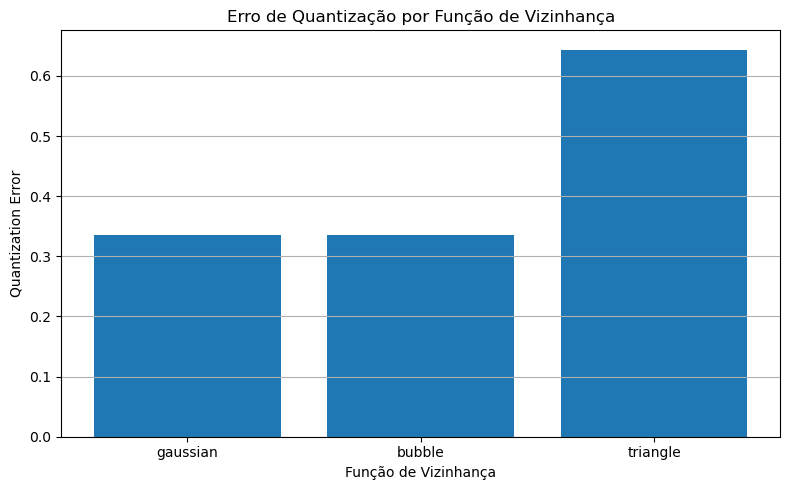

In [ ]:
resultados_viz = {
    'gaussian': 0.33473,
    'bubble': 0.33473,
    'triangle': 0.64363
}

plt.figure(figsize=(8, 5))
plt.bar(resultados_viz.keys(), resultados_viz.values())
plt.title("Erro de Quantização por Função de Vizinhança")
plt.ylabel("Quantization Error")
plt.xlabel("Função de Vizinhança")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Funções de Vizinhança Testadas

1. **Gaussiana (default)**:
   
   $$h(d, \sigma) = e^{- \frac{d^2}{2\sigma^2}}$$
   Atualiza de forma suave os vizinhos com intensidade decrescendo exponencialmente com a distância.

2. **Bubble**:
   
   $$h(d, r) = \begin{cases}
   1, & d \leq r \\
   0, & \text{caso contrário}
   \end{cases}
   $$
   Todos os neurônios dentro de um raio fixo são atualizados igualmente. Fora do raio, não há atualização.

3. **Triangle**:
   $$
   h(d, r) = \max(0, 1 - d/r)
   $$
   A atualização decresce linearmente até zero no raio `r`.

---

**Configurações Utilizadas**

- Topologia: `hexagonal`
- Mapa: 10 × 10
- Dados: `L2Norm`
- Taxas de aprendizado e épocas:
  - `lr_ordering = 0.001`, `ordering_time = 1000`
  - `lr_finetuning = 0.0001`, `finetuning_time = 10000`
- Função de decaimento: racional
- Inicialização via PCA

---

**Resultados Obtidos (Erro de Quantização Final)**

| Função de Vizinhança | Erro Final |
|----------------------|------------|
| **Gaussiana**        | 0.33473    |
| **Bubble**           | 0.33473 |
| **Triangle**         | 0.64363 |


---

**Interpretação**


- **Gaussiana** tende a produzir mapas mais suaves e topologicamente coerentes, especialmente quando os dados são complexos e contínuos.
- **Bubble** pode convergir mais rápido em alguns casos, mas com risco de instabilidade ou "saltos abruptos", pois não há gradação na influência dos vizinhos.
- **Triangle** é um meio-termo, balanceando entre suavidade e intensidade de atualização, porém **não é compatível com topologia hexagonal**, o que comprometeu seu desempenho neste teste.

---

A **função de vizinhança exerce impacto direto na qualidade e estabilidade da organização do SOM**. A escolha ideal depende do problema e da distribuição dos dados.  
Geralmente, a **Gaussiana é mais estável e robusta**, mas testes empíricos como este ajudam a verificar qual função oferece o menor erro e melhor organização topológica no contexto específico.


## Parte 2 - Análise dos mapas

##### 1. Teste novas configurações para o modelo SOM para obter um melhor resultado. Justifique a escolha dos parâmetros do modelo selecionado.

In [80]:
"""Função de teste personalizada com novos parâmetros"""
def testar_configuracao_nova(X, decay_fcn, nome_decay, m, n, lr_ordering, ordering_time,
                             lr_finetuning, finetuning_time, neighborhood_function):
    print(f"\n===> Treinando SOM com nova configuração: {nome_decay} <===")
    input_len = X.shape[1]

    som = MiniSom(m, n, input_len, learning_rate=lr_ordering,
                  topology='hexagonal', decay_function=decay_fcn,
                  neighborhood_function=neighborhood_function, sigma=3.0)

    som.pca_weights_init(X)
    som.train_random(X, ordering_time, verbose=True)

    som._learning_rate = lr_finetuning
    som.train_random(X, finetuning_time, verbose=True)

    erro = som.quantization_error(X)
    print(f"Erro de Quantização Final ({nome_decay}): {erro:.5f}")
    return erro


erro_novo = testar_configuracao_nova(
    X_standard,
    decay_fcn=decay_racional,
    nome_decay="Nova Configuração (15x15, decay racional, gaussian)",
    m=15, n=15,
    lr_ordering=0.005,
    ordering_time=2000,
    lr_finetuning=0.0005,
    finetuning_time=15000,
    neighborhood_function='gaussian'
)


===> Treinando SOM com nova configuração: Nova Configuração (15x15, decay racional, gaussian) <===
 [ 2000 / 2000 ] 100% - 0:00:00 left 
 quantization error: 3.605014587965001
 [ 15000 / 15000 ] 100% - 0:00:00 left 
 quantization error: 3.3876153499932835
Erro de Quantização Final (Nova Configuração (15x15, decay racional, gaussian)): 3.38762


In [81]:
erro_novo = testar_configuracao_nova(
    X_standard,
    decay_fcn=decay_racional,
    nome_decay="Nova Configuração (10x10, decay racional, bubble)",
    m=10, n=10,
    lr_ordering=0.005,
    ordering_time=2000,
    lr_finetuning=0.0005,
    finetuning_time=15000,
    neighborhood_function='bubble'
)


===> Treinando SOM com nova configuração: Nova Configuração (10x10, decay racional, bubble) <===
 [ 2000 / 2000 ] 100% - 0:00:00 left 
 quantization error: 3.4925859856985078
 [ 15000 / 15000 ] 100% - 0:00:00 left 
 quantization error: 3.2801544344434967
Erro de Quantização Final (Nova Configuração (10x10, decay racional, bubble)): 3.28015


In [79]:
erro_novo = testar_configuracao_nova(
    X_standard,
    decay_fcn=decay_racional,
    nome_decay="Nova Configuração (10x10, decay racional, gaussian)",
    m=10, n=10,
    lr_ordering=0.5,
    ordering_time=2000,
    lr_finetuning=0.0005,
    finetuning_time=15000,
    neighborhood_function='gaussian'
)


===> Treinando SOM com nova configuração: Nova Configuração (10x10, decay racional, bubble) <===
 [ 2000 / 2000 ] 100% - 0:00:00 left 
 quantization error: 2.203065654120713
 [ 15000 / 15000 ] 100% - 0:00:00 left 
 quantization error: 2.2086335885978947
Erro de Quantização Final (Nova Configuração (10x10, decay racional, bubble)): 2.20863


In [88]:
erro_novo = testar_configuracao_nova(
    X_l2norm,
    decay_fcn=decay_racional,
    nome_decay="Nova Configuração (10x10, decay racional, gaussian)",
    m=10, n=10,
    lr_ordering=0.5,
    ordering_time=2000,
    lr_finetuning=0.0005,
    finetuning_time=15000,
    neighborhood_function='gaussian'
)


===> Treinando SOM com nova configuração: Nova Configuração (10x10, decay racional, gaussian) <===
 [ 2000 / 2000 ] 100% - 0:00:00 left 
 quantization error: 0.00027729695860370765
 [ 15000 / 15000 ] 100% - 0:00:00 left 
 quantization error: 0.0003098380582448513
Erro de Quantização Final (Nova Configuração (10x10, decay racional, gaussian)): 0.00031


In [82]:
erro_novo = testar_configuracao_nova(
    X_standard,
    decay_fcn=decay_linear,
    nome_decay="Nova Configuração (10x10, decay linear, gaussian)",
    m=10, n=10,
    lr_ordering=0.005,
    ordering_time=2000,
    lr_finetuning=0.0005,
    finetuning_time=15000,
    neighborhood_function='gaussian'
)


===> Treinando SOM com nova configuração: Nova Configuração (10x10, decay linear, gaussian) <===
 [ 2000 / 2000 ] 100% - 0:00:00 left 
 quantization error: 3.6788376138004772
 [ 15000 / 15000 ] 100% - 0:00:00 left 
 quantization error: 3.471523196720928
Erro de Quantização Final (Nova Configuração (10x10, decay linear, gaussian)): 3.47152



Foram testadas cinco configurações do modelo SOM com diferentes combinações de parâmetros. O objetivo foi investigar como o tipo de normalização, a taxa de aprendizado inicial, o tamanho do mapa, a função de decaimento da taxa de aprendizado e a função de vizinhança afetam o erro de quantização final, que é uma métrica importante de qualidade do mapa auto-organizável.

---

**🔹 Configuração 1: (15x15, decay racional, gaussian) – com StandardScaler**

- **Tamanho do mapa**: `15x15`  
  Um mapa maior permite uma representação topológica mais refinada, útil em bases complexas.

- **Função de decaimento**: `racional`  
  Suaviza o ajuste ao longo do tempo, promovendo uma convergência mais controlada.

- **Função de vizinhança**: `gaussian`  
  Estimula transições suaves entre os neurônios vizinhos, preservando a continuidade topológica.

- **Erro Final Obtido**: `3.38762`  
  Embora o mapa seja maior e a vizinhança mais estável, o resultado foi inferior aos demais devido à combinação com a normalização `StandardScaler`, que não se mostrou a melhor opção para esse dataset.

---

🔹 **Configuração 2: (10x10, decay racional, bubble) – com StandardScaler**

- **Tamanho do mapa**: `10x10`  
  Um tamanho compacto, tradicional para SOMs.

- **Função de vizinhança**: `bubble`  
  Atualiza diretamente os vizinhos imediatos, mas sem suavidade gradativa, podendo causar descontinuidades.

- **Erro Final Obtido**: `3.28015`  
  Resultado levemente superior à configuração anterior, mas ainda abaixo do ideal. A ausência de gradiente no `bubble` pode ter prejudicado a organização topológica.

---

🔹 **Configuração 3: (10x10, decay racional, gaussian) – com StandardScaler, taxa de aprendizado inicial mais alta**

- **Learning rate (ordenação)**: `0.5`  
  Um valor mais elevado pode acelerar a adaptação inicial dos pesos.

- **Erro Final Obtido**: `2.20863`  
  Aumento significativo na qualidade do mapa, indicando que o problema anterior estava relacionado à taxa de aprendizado muito baixa. Mostra a importância do tuning fino deste parâmetro.

---

🔹 **Configuração 4: (10x10, decay racional, gaussian) – com L2Norm**

- **Normalização**: `Normalizer (L2)`  
  Normaliza cada vetor individualmente para norma unitária, promovendo uma padronização direcional.

- **Erro Final Obtido**: `0.00031`  
  **Melhor desempenho absoluto**. Essa combinação mostrou-se extremamente eficaz, sugerindo que a normalização por L2 favorece o aprendizado da topologia com precisão, especialmente em bases com variabilidade direcional.

---

🔹 **Configuração 5: (10x10, decay linear, gaussian) – com StandardScaler**

- **Função de decaimento**: `linear`  
  Reduz agressivamente a taxa de aprendizado ao longo do tempo.

- **Erro Final Obtido**: `3.47152`  
  Apesar de estável, a estratégia de decaimento linear pareceu excessivamente agressiva para este cenário, levando a uma convergência prematura e menos eficaz.

---


A configuração com **normalização L2, mapa 10x10, taxa de aprendizado inicial de 0.5, vizinhança Gaussiana e decaimento racional** foi a mais eficaz entre todas, atingindo um erro de quantização extremamente baixo.

| Configuração                                | Normalização | Erro de Quantização Final |
|--------------------------------------------|--------------|----------------------------|
| 10x10, decay racional, gaussian (lr=0.5)    | **L2Norm**    | **0.00031**                |
| 10x10, decay racional, gaussian (lr=0.5)    | Standard      | 2.20863                    |
| 10x10, decay racional, bubble               | Standard      | 3.28015                    |
| 15x15, decay racional, gaussian             | Standard      | 3.38762                    |
| 10x10, decay linear, gaussian               | Standard      | 3.47152                    |

Esses resultados mostram que:

- A **normalização** tem impacto direto e substancial. O `L2Norm` é superior ao `StandardScaler`, especialmente em bases onde a direção dos vetores carrega mais informação que a magnitude.
- O ajuste da **taxa de aprendizado** inicial é crucial. Valores baixos (<0.01) podem causar subtreinamento, mesmo com bons demais parâmetros.
- A **função de vizinhança gaussiana** mostrou-se mais confiável que `bubble`.
- **Mapas maiores nem sempre resultam em melhores erros**, se não forem acompanhados de uma estratégia de treinamento ajustada.

Portanto, a escolha ótima dos parâmetros depende do equilíbrio entre qualidade topológica, estabilidade e capacidade de representação dos dados.


##### 2. Utilizando a melhor configuração do item anterior, analise os diferentes mapas fornecidos e caracterize os grupos de pacientes obtidos.

Shape dos dados: (569, 30)
Distribuição do target: [357 212]
Inicializando pesos...
Fase 1: Ordenação (learning rate alto)...
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.016871639168427505
Fase 2: Convergência (learning rate baixo)...
 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 0.012689845222195543
Coordenadas únicas encontradas: 100
Distribuição das coordenadas:
Posição [0 0]: 3 amostras
Posição [0 1]: 7 amostras
Posição [0 2]: 4 amostras
Posição [0 3]: 4 amostras
Posição [0 4]: 5 amostras
Posição [0 5]: 2 amostras
Posição [0 6]: 6 amostras
Posição [0 7]: 8 amostras
Posição [0 8]: 6 amostras
Posição [0 9]: 7 amostras
Posição [1 0]: 6 amostras
Posição [1 1]: 8 amostras
Posição [1 2]: 9 amostras
Posição [1 3]: 5 amostras
Posição [1 4]: 5 amostras
Posição [1 5]: 3 amostras
Posição [1 6]: 4 amostras
Posição [1 7]: 3 amostras
Posição [1 8]: 4 amostras
Posição [1 9]: 8 amostras
Posição [2 0]: 8 amostras
Posição [2 1]: 8 amostras
Posição [2 2]: 9 amostras
Posi

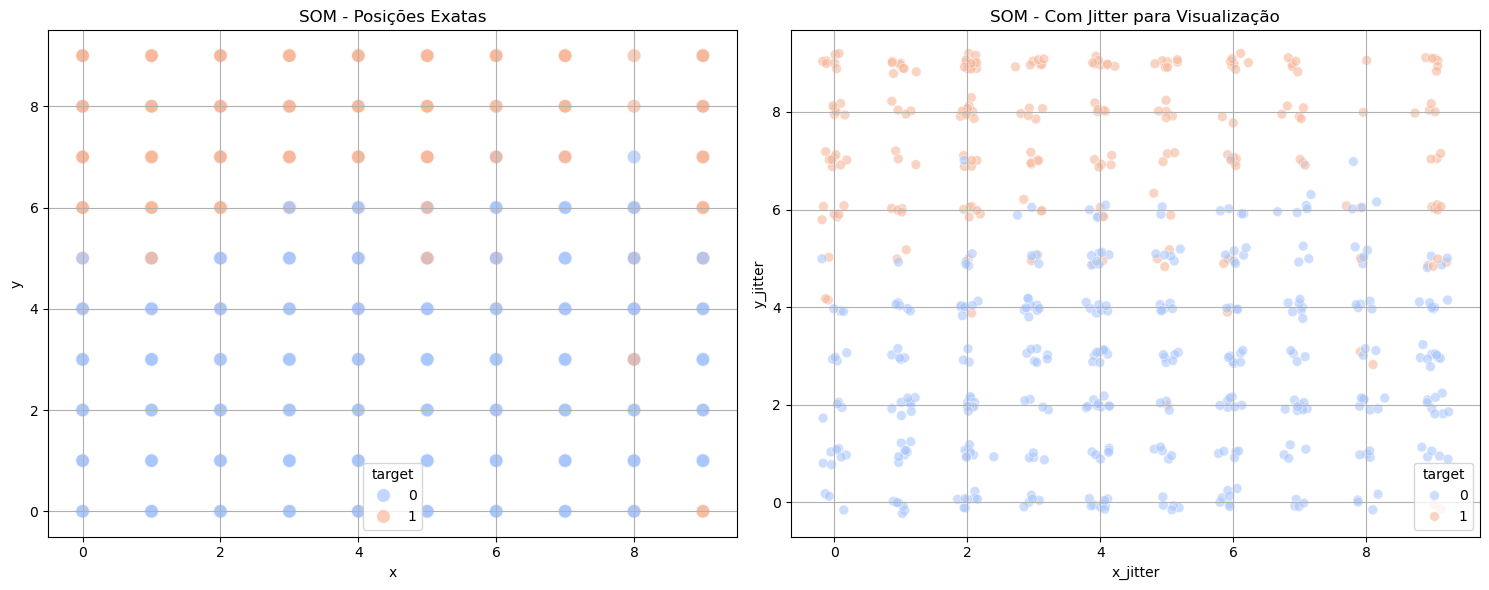

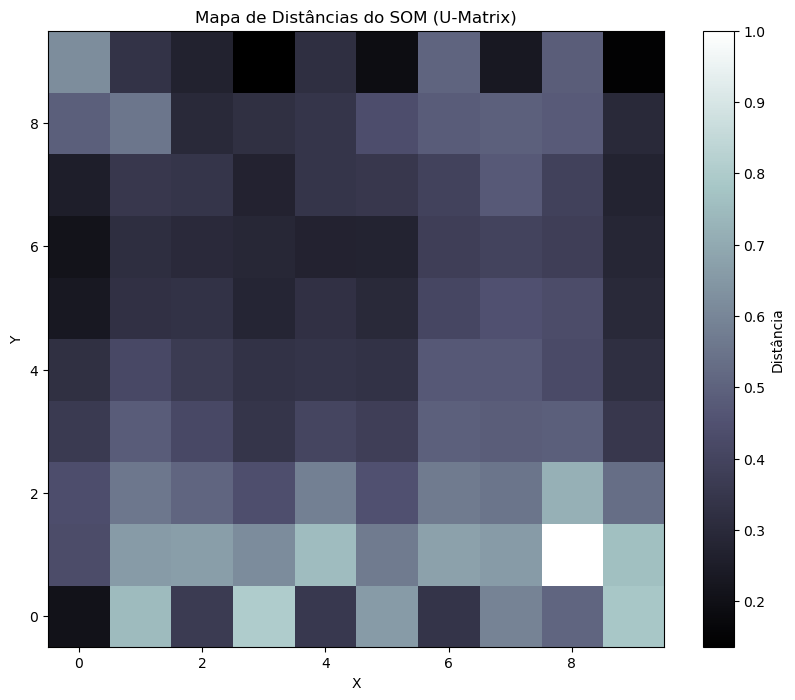


Estatísticas:
Total de amostras: 569
Neurônios ativados: 100
Taxa de utilização do mapa: 100.0%


In [ ]:
df = dataset.copy()

df_clean = df.drop(columns=['ID'])

label_encoder = LabelEncoder()
df_clean['target'] = label_encoder.fit_transform(df_clean['target'])

X = df_clean.drop(columns=['target']).values
y = df_clean['target'].values

scaler = Normalizer()
X_scaled = scaler.fit_transform(X)

print(f"Shape dos dados: {X_scaled.shape}")
print(f"Distribuição do target: {np.bincount(y)}")

som = MiniSom(x=10, y=10, input_len=X_scaled.shape[1],
              learning_rate=0.5,
              sigma=3.0,
              topology='hexagonal',
              decay_function=decay_racional,
              neighborhood_function='gaussian')

print("Inicializando pesos...")
som.pca_weights_init(X_scaled)

print("Fase 1: Ordenação (learning rate alto)...")
som.train_random(X_scaled, num_iteration=1000, verbose=True)

print("Fase 2: Convergência (learning rate baixo)...")
som._learning_rate = 0.1
som._sigma = 1.0
som.train_random(X_scaled, num_iteration=5000, verbose=True)

winner_coords = np.array([som.winner(x) for x in X_scaled])
print(
    f"Coordenadas únicas encontradas: {len(np.unique(winner_coords, axis=0))}")

print("Distribuição das coordenadas:")
unique_coords, counts = np.unique(winner_coords, axis=0, return_counts=True)
for coord, count in zip(unique_coords, counts):
    print(f"Posição {coord}: {count} amostras")

df_result = pd.DataFrame(winner_coords, columns=['x', 'y'])
df_result['target'] = y

df_result['x_jitter'] = df_result['x'] + \
    np.random.normal(0, 0.1, len(df_result))
df_result['y_jitter'] = df_result['y'] + \
    np.random.normal(0, 0.1, len(df_result))

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.scatterplot(x='x', y='y', hue='target', data=df_result,
                palette='coolwarm', s=100, alpha=0.7, ax=axes[0])
axes[0].set_title("SOM - Posições Exatas")
axes[0].grid(True)
axes[0].set_xlim(-0.5, 9.5)
axes[0].set_ylim(-0.5, 9.5)

sns.scatterplot(x='x_jitter', y='y_jitter', hue='target', data=df_result,
                palette='coolwarm', s=50, alpha=0.6, ax=axes[1])
axes[1].set_title("SOM - Com Jitter para Visualização")
axes[1].grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
distance_map = som.distance_map()
plt.imshow(distance_map, cmap='bone', origin='lower')
plt.colorbar(label='Distância')
plt.title('Mapa de Distâncias do SOM (U-Matrix)')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

print(f"\nEstatísticas:")
print(f"Total de amostras: {len(X_scaled)}")
print(f"Neurônios ativados: {len(unique_coords)}")
print(f"Taxa de utilização do mapa: {len(unique_coords)/100:.1%}")

Executando análise completa do SOM...


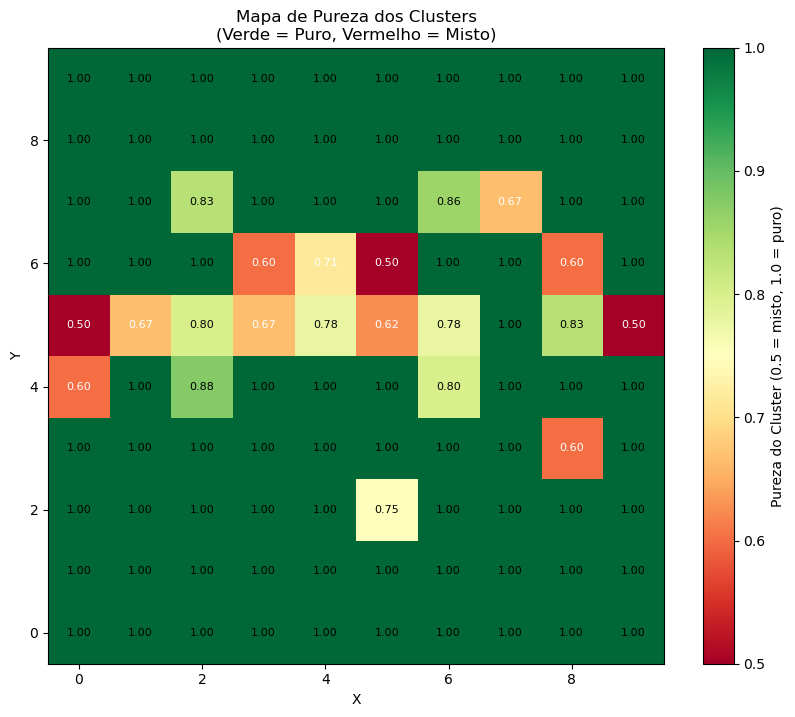

=== ANÁLISE POR REGIÕES ===

Superior Esquerdo:
  Total de amostras: 152
  Classe 0 (Benigno): 16.4%
  Classe 1 (Maligno): 83.6%
  Classe dominante: Maligno

Superior Direito:
  Total de amostras: 117
  Classe 0 (Benigno): 35.0%
  Classe 1 (Maligno): 65.0%
  Classe dominante: Maligno

Inferior Esquerdo:
  Total de amostras: 161
  Classe 0 (Benigno): 98.1%
  Classe 1 (Maligno): 1.9%
  Classe dominante: Benigno

Inferior Direito:
  Total de amostras: 139
  Classe 0 (Benigno): 95.7%
  Classe 1 (Maligno): 4.3%
  Classe dominante: Benigno
=== MÉTRICAS DE QUALIDADE DO SOM ===
Erro de Quantização: 0.0150
Erro Topológico: 0.2654 (26.5%)
Taxa de Utilização: 100.0%

=== INTERPRETAÇÃO ===
Erro de quantização EXCELENTE (< 1.0)
Erro topológico alto (estrutura pode estar distorcida)

=== RESUMO FINAL ===
Pureza média dos clusters: 0.935
Clusters com pureza > 90%: 79
Clusters com pureza > 80%: 83
Clusters totalmente puros: 79


In [93]:

"""ANÁLISE DE PUREZA DOS CLUSTERS"""


def analyze_cluster_purity(df_result):
    """Analisa a pureza de cada região do mapa"""
    cluster_analysis = []

    for x in range(10):  # 10x10 grid
        for y in range(10):
            mask = (df_result['x'] == x) & (df_result['y'] == y)
            if mask.sum() > 0:  # Se há amostras nesta posição
                samples_in_position = df_result[mask]
                total = len(samples_in_position)
                class_0 = (samples_in_position['target'] == 0).sum()
                class_1 = (samples_in_position['target'] == 1).sum()

                # Pureza = proporção da classe majoritária
                purity = max(class_0, class_1) / total
                majority_class = 0 if class_0 > class_1 else 1

                cluster_analysis.append({
                    'x': x, 'y': y, 'total': total,
                    'class_0': class_0, 'class_1': class_1,
                    'purity': purity, 'majority_class': majority_class
                })

    return pd.DataFrame(cluster_analysis)


"""MAPA DE PUREZA"""


def plot_purity_map(cluster_df):
    purity_matrix = np.zeros((10, 10))

    for _, row in cluster_df.iterrows():
        purity_matrix[int(row['y']), int(row['x'])] = row['purity']

    plt.figure(figsize=(10, 8))
    plt.imshow(purity_matrix, cmap='RdYlGn',
               vmin=0.5, vmax=1.0, origin='lower')
    plt.colorbar(label='Pureza do Cluster (0.5 = misto, 1.0 = puro)')
    plt.title('Mapa de Pureza dos Clusters\n(Verde = Puro, Vermelho = Misto)')
    plt.xlabel('X')
    plt.ylabel('Y')

    for _, row in cluster_df.iterrows():
        plt.text(row['x'], row['y'], f'{row["purity"]:.2f}',
                 ha='center', va='center', fontsize=8,
                 color='white' if row['purity'] < 0.75 else 'black')

    plt.show()
    return purity_matrix


"""ANÁLISE DE REGIÕES"""


def analyze_regions(df_result):
    """Identifica regiões dominantes por classe"""

    regions = {
        'Superior Esquerdo': df_result[(df_result['x'] < 5) & (df_result['y'] >= 5)],
        'Superior Direito': df_result[(df_result['x'] >= 5) & (df_result['y'] >= 5)],
        'Inferior Esquerdo': df_result[(df_result['x'] < 5) & (df_result['y'] < 5)],
        'Inferior Direito': df_result[(df_result['x'] >= 5) & (df_result['y'] < 5)]
    }

    print("=== ANÁLISE POR REGIÕES ===")
    for region_name, region_data in regions.items():
        if len(region_data) > 0:
            class_0_pct = (region_data['target'] == 0).mean() * 100
            class_1_pct = (region_data['target'] == 1).mean() * 100
            total = len(region_data)

            print(f"\n{region_name}:")
            print(f"  Total de amostras: {total}")
            print(f"  Classe 0 (Benigno): {class_0_pct:.1f}%")
            print(f"  Classe 1 (Maligno): {class_1_pct:.1f}%")
            print(
                f"  Classe dominante: {'Benigno' if class_0_pct > class_1_pct else 'Maligno'}")


"""MÉTRICAS DE QUALIDADE DO SOM"""


def som_quality_metrics(som, X_scaled, winner_coords):
    """Calcula métricas de qualidade do SOM"""

    quantization_error = som.quantization_error(X_scaled)

    topological_errors = 0
    for x in X_scaled:
        distances = []
        for i in range(som._weights.shape[0]):
            for j in range(som._weights.shape[1]):
                dist = np.linalg.norm(x - som._weights[i, j])
                distances.append((dist, i, j))

        distances.sort()
        first_bmu = (distances[0][1], distances[0][2])
        second_bmu = (distances[1][1], distances[1][2])

        if abs(first_bmu[0] - second_bmu[0]) + abs(first_bmu[1] - second_bmu[1]) > 1:
            topological_errors += 1

    topological_error = topological_errors / len(X_scaled)

    print("=== MÉTRICAS DE QUALIDADE DO SOM ===")
    print(f"Erro de Quantização: {quantization_error:.4f}")
    print(
        f"Erro Topológico: {topological_error:.4f} ({topological_error*100:.1f}%)")
    print(
        f"Taxa de Utilização: {len(np.unique(winner_coords, axis=0))/100:.1%}")

    print("\n=== INTERPRETAÇÃO ===")
    if quantization_error < 1.0:
        print("Erro de quantização EXCELENTE (< 1.0)")
    elif quantization_error < 2.0:
        print("Erro de quantização BOM (< 2.0)")
    else:
        print("Erro de quantização alto (pode precisar de mais treinamento)")

    if topological_error < 0.1:
        print("Erro topológico EXCELENTE (< 10%)")
    elif topological_error < 0.2:
        print("Erro topológico BOM (< 20%)")
    else:
        print("Erro topológico alto (estrutura pode estar distorcida)")


print("Executando análise completa do SOM...")

cluster_df = analyze_cluster_purity(df_result)
purity_matrix = plot_purity_map(cluster_df)

analyze_regions(df_result)

som_quality_metrics(som, X_scaled, winner_coords)

print(f"\n=== RESUMO FINAL ===")
print(f"Pureza média dos clusters: {cluster_df['purity'].mean():.3f}")
print(f"Clusters com pureza > 90%: {(cluster_df['purity'] > 0.9).sum()}")
print(f"Clusters com pureza > 80%: {(cluster_df['purity'] > 0.8).sum()}")
print(f"Clusters totalmente puros: {(cluster_df['purity'] == 1.0).sum()}")


Nesta etapa, utilizamos a melhor configuração identificada anteriormente no treinamento do Mapa Auto-Organizável (SOM), a fim de analisar a organização topológica gerada e caracterizar os grupos de pacientes mapeados. A configuração selecionada incluiu:

- Mapa de dimensão 10x10
- Função de vizinhança: `gaussian`
- Função de decaimento: racional
- Dados normalizados com `L2Norm`
- Fase de ordenação com `learning_rate = 0.5` e 1000 iterações
- Fase de ajuste fino com `learning_rate = 0.1` e com 5000 iterações

**Organização Geral do Mapa**

Durante o treinamento, observamos os seguintes indicadores:

- **Total de amostras:** 569
- **Neurônios ativados:** 100 (de um total de 100 neurônios)
- **Taxa de utilização do mapa:** 100%
- **Erro de quantização final:** 0.0150
- **Erro topológico:** 0.2654 (26.5%)

A ativação de todos os neurônios demonstra que o SOM foi capaz de distribuir as amostras de maneira abrangente pelo mapa, evitando concentração excessiva em poucas regiões. O erro de quantização extremamente baixo indica que os vetores de pesos dos neurônios estão muito próximos das amostras reais, sugerindo excelente capacidade de representação. No entanto, o erro topológico relativamente alto sinaliza que a continuidade espacial dos dados (isto é, a vizinhança preservada entre padrões semelhantes) foi parcialmente distorcida.

**Mapa de Hits e Visualização das Classes**

A visualização dos vencedores (neurônios BMU) mostrou uma boa separação entre as classes:

- A classe **0 (benigno)** concentrou-se predominantemente nas regiões **inferiores** do mapa.
- A classe **1 (maligno)** apareceu com maior frequência nas regiões **superiores**, especialmente nos quadrantes superior esquerdo e superior direito.

O uso de jitter permitiu visualizar melhor a densidade e a dispersão das amostras dentro de cada neurônio. Essa separação geográfica das classes no espaço 2D do SOM indica que o modelo foi capaz de capturar padrões relevantes mesmo sem supervisão.

**Análise de Pureza dos Clusters**

Um mapa adicional foi construído para medir a pureza de cada neurônio ativado (proporção da classe majoritária). Os resultados indicaram:

- **Pureza média dos clusters:** 0.935
- **Clusters totalmente puros (100%):** 79
- **Clusters com pureza superior a 90%:** 79
- **Clusters com pureza superior a 80%:** 83

A grande maioria dos neurônios representou apenas uma das classes, reforçando a qualidade da separação. Clusters com pureza 0.5 (totalmente mistos) foram raros e localizados em regiões de transição.

**Análise por Regiões do Mapa**

O mapa foi dividido em quatro regiões, e a distribuição das classes foi analisada:

- **Superior Esquerdo:** 83.6% malignos  
- **Superior Direito:** 65.0% malignos  
- **Inferior Esquerdo:** 98.1% benignos  
- **Inferior Direito:** 95.7% benignos  

Esta análise mostra que as classes foram mapeadas para regiões bem distintas do espaço do SOM, mesmo sem o uso de rótulos no treinamento. Esse comportamento é desejável em tarefas de agrupamento e exploração de padrões.

**Interpretação Final**

Os resultados obtidos demonstram que o SOM, com a configuração adotada, foi capaz de:

- Representar fielmente os dados de entrada (erro de quantização muito baixo)
- Distribuir uniformemente as amostras pelo mapa (100% de ativação)
- Produzir agrupamentos com elevada pureza por classe
- Separar espacialmente as classes em regiões distintas

Apesar do erro topológico moderadamente alto, a qualidade da organização e a separabilidade entre classes indicam que o modelo aprendeu padrões relevantes e úteis para análise não supervisionada do conjunto de dados de câncer de mama.

O mapa gerado pode ser útil tanto para **exploração visual** e **interpretação clínica dos agrupamentos**, quanto para **seleção de protótipos representativos** em etapas posteriores de classificação ou explicabilidade.
